In [1]:
# The data incubator project by Maxime M. Ali-Dib

# Import libraries

from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers.core import Dropout, Reshape
from keras.regularizers import l2

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
K.set_image_dim_ordering('tf')
from PIL import Image
import matplotlib
from utils import *
import cv2
from keras import __version__ as keras_version
k2 = True if keras_version[0] == '2' else False
from keras.models import load_model
from __future__ import print_function
import time
from PIL import Image
import numpy as np
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave




/home/mad/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# This routine will Transfer the style of a lunar surface image to earth landscape 
#   ( artistic Neural style transfer)
# Code based on https://harishnarayanan.org/writing/artistic-style-transfer/
# It uses VGG16 with imagenet weights as a model, but I intend to swipe it for the model used earlier. 
# The input "content" image is for the Yosemite valley and the "style image" is a Lunar surface image

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))


def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))


def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
    


height = 512
width = 512

content_image_path = './Yosemite_Valley.jpg'
content_image = Image.open(content_image_path,mode = 'r').convert('RGB')
content_image = content_image.resize((width, height))


style_image_path = './moon_surface.jpg'
style_image = Image.open(style_image_path, mode = 'r').convert('RGB')
style_image = style_image.resize((width, height))


content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)



content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]



content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))



input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)





model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

print (model.summary())

layers = dict([(layer.name, layer.output) for layer in model.layers])


content_weight = 0.025
style_weight = 0.5
total_variation_weight = 1.0

loss = backend.variable(0.)


layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl



loss += total_variation_weight * total_variation_loss(combination_image)

grads = backend.gradients(loss, combination_image)
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)


evaluator = Evaluator()

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 2


for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (3, 512, 512, 3)      0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (3, 512, 512, 64)     1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (3, 512, 512, 64)     36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (3, 256, 256, 64)     0           block1_conv2[0][0]               
___________________________________________________________________________________________

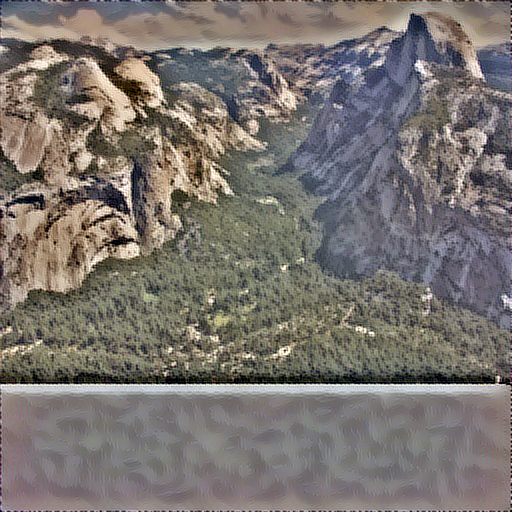

In [3]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)